In [103]:
import json
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [368]:
def get_iou(true, pred):
    x11, y11, x12, y12 = true[0][0], true[0][1], true[1][0], true[1][1]
    x21, y21, x22, y22 = pred[0][0], pred[0][1], pred[1][0], pred[1][1]
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def evaluate(annotationPath, predictionPath, confidence_threshold, iou_threshold=0.5, onlyWithKidneys=False):
    with open(annotationPath) as anno_file:
        annots = json.loads(json.load(anno_file))

    with open(predictionPath, 'rb') as handle:
        predictions = pickle.load(handle, encoding="bytes")
    
    for p in predictions:
        predictionsStr[p.decode("utf-8") ] = predictions[p]
        
    print(len(predictions), len(predictionsStr))
    
    results = {"iou": {}, 'precision': {}, 'recall': {}}
    for setType in ["train", "val", "test"]:
        ious = []
        true_positives = 0
        false_positives = 0
        false_negative = 0
        true_negative = 0
        
        for i, annot in enumerate(annots):
            if annot['set'] == setType:
                path = os.path.join('../../data/mpii/images/', annot['img_paths'].replace('\\', '/'))
                leftKidneyTrue = [annot['obj_locations'][0][:2], annot['obj_locations'][1][:2]]
                rightKidneyTrue = [annot['obj_locations'][2][:2], annot['obj_locations'][3][:2]]
                
                
                    
                prediction = predictionsStr[path]

                leftKidneyConfidence = min(prediction[0][2], prediction[1][2])
                rightKidneyConfidence = min(prediction[2][2], prediction[3][2])

                leftKidneyPred = [[0,0], [0,0]]
                rightKidneyPred = [[0,0], [0,0]]
                if leftKidneyConfidence > confidence_threshold:
                    leftKidneyPred = [prediction[0][:2], prediction[1][:2]]
                if rightKidneyConfidence > confidence_threshold:
                    rightKidneyPred = [prediction[2][:2], prediction[3][:2]]
                   
                iou = get_iou(leftKidneyTrue, leftKidneyPred)
                if np.sum(leftKidneyTrue) > 0:
                    ious.append(iou)
                if iou >= iou_threshold and np.sum(leftKidneyTrue) > 0: true_positives += 1 
                if iou >= iou_threshold and np.sum(leftKidneyTrue) == 0: false_positives += 1
                if iou < iou_threshold and np.sum(leftKidneyTrue) > 0: false_negative += 1
                if iou < iou_threshold and np.sum(leftKidneyTrue) == 0: true_negative += 1
                
                iou = get_iou(rightKidneyTrue, rightKidneyPred)
                if np.sum(rightKidneyTrue):
                    ious.append(iou)
                if iou >= iou_threshold and np.sum(rightKidneyTrue) > 0: true_positives += 1 
                if iou >= iou_threshold and np.sum(rightKidneyTrue) == 0: false_positives += 1
                if iou < iou_threshold and np.sum(rightKidneyTrue) > 0: false_negative += 1
                if iou < iou_threshold and np.sum(rightKidneyTrue) == 0: true_negative += 1
                    
        results['iou'][setType] = np.mean(ious)
        results['precision'][setType] = true_positives/(true_positives + false_positives)
        results['recall'][setType] = true_positives/(true_positives + false_negative)
    return results
    

In [390]:
confidence_threshold = 0.000
iou_threshold = 0.5
onlyWithKidneys = False

results = {'shuffledPatientsAug': [],'selectedPatientsAug': [], 'shuffledPatientsNoAug': [], 'selectedPatientsNoAug':[]}
for trainType in results.keys():
    result = evaluate(os.path.join('..\src\models', trainType, 'mpii_annotations.json'),
             os.path.join('..\src\models', trainType, 'predictions.pickle'),
            confidence_threshold=confidence_threshold,
            iou_threshold=iou_threshold,
            onlyWithKidneys=onlyWithKidneys)
    results[trainType] = result
print(results)

4939 4939
4939 4939
4939 4939
4939 4939
{'shuffledPatientsAug': {'iou': {'train': 0.669180802706938, 'val': 0.6613671284172778, 'test': 0.6657603683901746}, 'precision': {'train': 0.6539923954372624, 'val': 0.6173361522198731, 'test': 0.6912650602409639}, 'recall': {'train': 0.900523560209424, 'val': 0.8716417910447761, 'test': 0.8912621359223301}}, 'selectedPatientsAug': {'iou': {'train': 0.6583602766391883, 'val': 0.6588564276086122, 'test': 0.6277729833880255}, 'precision': {'train': 1.0, 'val': 1.0, 'test': 1.0}, 'recall': {'train': 0.872255489021956, 'val': 0.8736263736263736, 'test': 0.812133072407045}}, 'shuffledPatientsNoAug': {'iou': {'train': 0.5999358965839021, 'val': 0.5763455670055639, 'test': 0.5796585239535326}, 'precision': {'train': 1.0, 'val': 1.0, 'test': 1.0}, 'recall': {'train': 0.7611256544502618, 'val': 0.7134328358208956, 'test': 0.7417475728155339}}, 'selectedPatientsNoAug': {'iou': {'train': 0.6559344094713971, 'val': 0.6433262206495607, 'test': 0.627597894929

0.6657603683901746


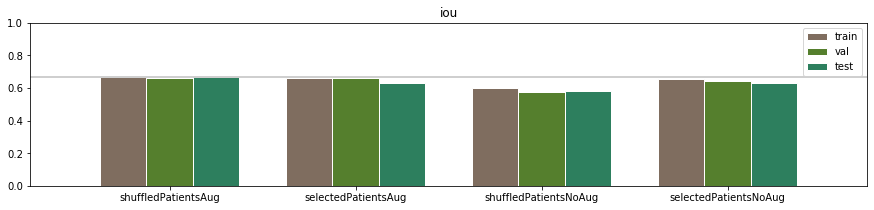

1.0


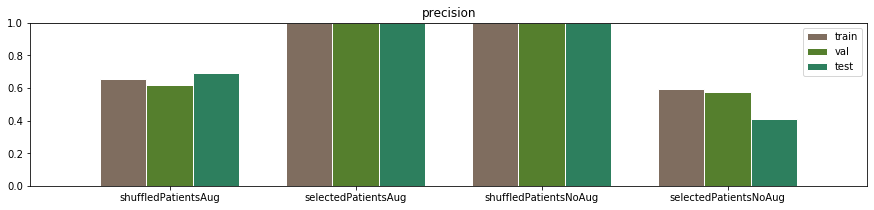

0.8912621359223301


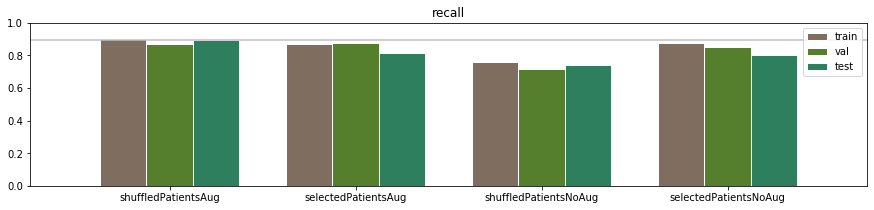

In [391]:
barWidth = 0.25

colors = ['#7f6d5f', '#557f2d', '#2d7f5e']
for metrics in ['iou', 'precision', 'recall']:
    plt.figure(figsize=(15, 3))
    maxx = 0
    for i, setType in enumerate(['train','val', 'test']):
        r = np.arange(len(results.keys())) + barWidth*i
        y = []
        for trainType in results.keys():
            y.append(results[trainType][metrics][setType])
            if setType == 'test':
                maxx = max(max(y), maxx)
        plt.bar(r, y, color=colors[i], width=barWidth, edgecolor='white', label=setType)
    
    plt.title(metrics)
    plt.xticks([r + barWidth for r in range(len(setType))], results.keys())
    plt.hlines(maxx, xmin=-10, xmax=10, color='silver')
    print(maxx)
    plt.xlim(-0.5, 4)
    plt.ylim(0,1)
    plt.legend()
    plt.show()



C:\Users\demet\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')


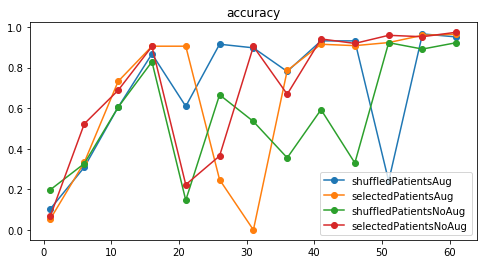

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')


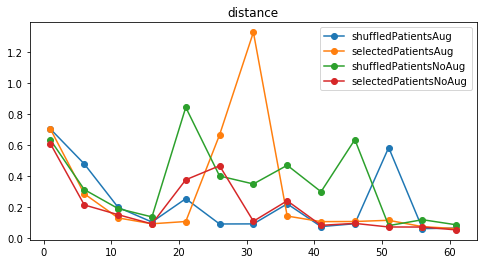

In [231]:
import pandas as pd
metrics = {2: 'accuracy', 5: 'distance'}
for m in metrics:
    plt.figure(figsize=(8,4))
    for trainType in list(results.keys()):
        data = pd.DataFrame(pd.read_table(os.path.join('../src/models/',trainType,'val.txt'), sep=' ', header = None))
        print(data.columns)
        x = np.array(data[1]).astype(int)[:13] + 1
        y = np.array(data[m].astype(float))[:13] 
        plt.plot(x,y, label=trainType, marker='o')
    plt.title(metrics[m])
    plt.legend()
    plt.show()